In [79]:
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words=stopwords.words("english")
new_stopping_words = stop_words[:len(stop_words)-36]
new_stopping_words.remove("not")
nltk.download('punkt')
nltk.download('wordnet')

from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *

[nltk_data] Downloading package stopwords to /Users/sky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2022-12-15 01:44:32.769780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

In [4]:

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

/Users/sky/.pyenv/versions/3.7.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sky/.pyenv/versions/3.7.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sky/.pyenv/versions/3.7.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

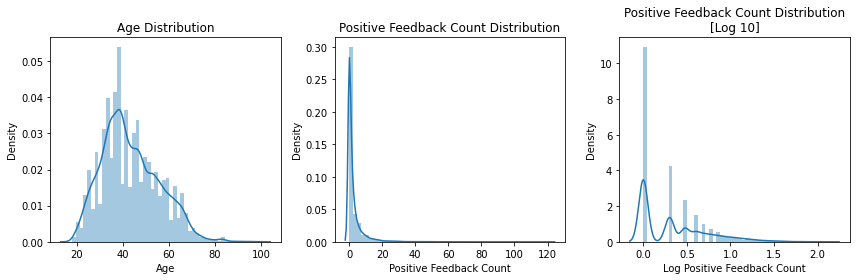

In [5]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

# Distribution of Clothing ID to Understand Product Popularity

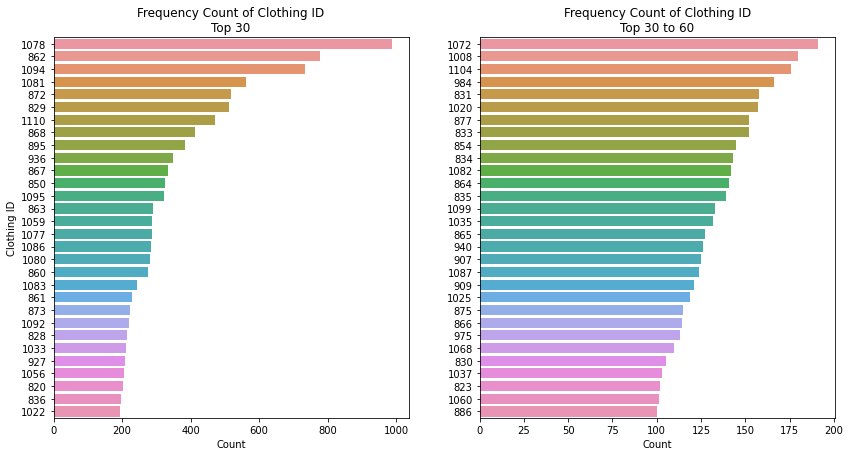

Dataframe Dimension: 22628 Rows


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.4848,103.396022,862.0,862.0,1078.0,1094.0,1094.0
Age,42.7248,12.150429,18.0,34.0,41.0,51.0,99.0
Rating,4.1892,1.104306,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.8184,0.385592,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.8624,6.773021,0.0,0.0,1.0,3.0,98.0
Word Count,60.5912,28.731486,2.0,36.0,60.0,89.0,115.0
Character Count,310.8604,144.836158,16.0,189.0,305.0,469.0,504.0
Label,0.9024,0.296832,0.0,1.0,1.0,1.0,1.0


In [6]:
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("Dataframe Dimension: {} Rows".format(df.shape[0]))
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

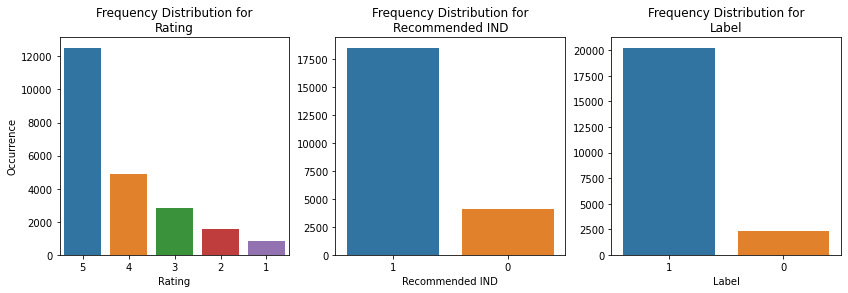

In [7]:
cat_dtypes = ["Rating","Recommended IND","Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

In [8]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]]

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comfortable,4
1,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5
2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5
4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5
...,...,...,...
23481,Great dress for many occasions,I was very happy to snag this dress at such a great price! it's very easy to slip on and has a very flattering cut and color combo.,5
23482,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.\nnot for me but maybe for others. just ok.",3
23483,"Cute, but see through","This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with different fabric, it would have been great.",3
23484,"Very cute dress, perfect for summer parties and we","I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this dress was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!",3


In [9]:
import nltk
nltk.download('vader_lexicon')
  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:

SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

In [11]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,8,53,1,0.8932,0.272,0.000,0.728,Positive
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,62,303,1,0.9729,0.664,0.000,0.336,Positive
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses,98,500,1,0.9427,0.792,0.027,0.181,Positive
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,22,124,1,0.5727,0.340,0.226,0.434,Positive
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,36,192,1,0.9291,0.700,0.000,0.300,Positive


In [12]:
stopwords = set(STOPWORDS)
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

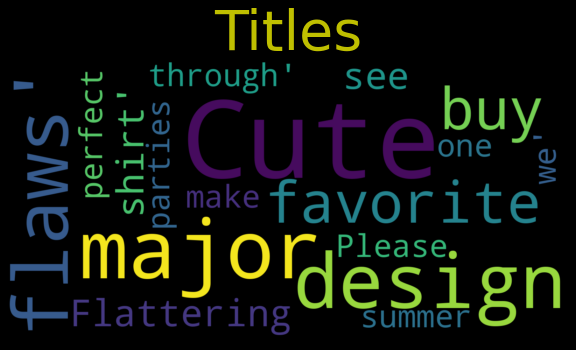

In [13]:
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= df.Title[df.Title.notnull()].astype(str).values,
      title="Titles",
      stopwords= new_stop,
      size = (7,4))

In [14]:
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

In [15]:
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

In [16]:
ps = PorterStemmer()
stop_words = set(STOPWORDS)

In [17]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row


In [18]:
all_words = nltk.FreqDist(df['Review Text']) # Calculate word occurrence from whole block of text

vocab_count = 200
word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))

Number of words columns (One Hot Encoding): 22621


In [19]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment,tokenized
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,8,53,1,0.8932,0.272,0.000,0.728,Positive,"[absolut, wonder, -, silki, sexi, comfort]"
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,62,303,1,0.9729,0.664,0.000,0.336,Positive,"[love, dress, !, 's, sooo, pretti, ., happen, find, store, ,, 'm, glad, bc, never, order, onlin, bc, 's, petit, ., bought, petit, 5, '8""., love, length, -, hit, littl, knee, ., definit, true, midi, someon, truli, petit, .]"
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses,98,500,1,0.9427,0.792,0.027,0.181,Positive,"[high, hope, dress, realli, want, work, ., initi, order, petit, small, (mi, usual, size, ), found, outrag, small, ., small, fact, zip, !, reorder, petit, medium, ,, ok, ., overal, ,, top, half, comfort, fit, nice, ,, bottom, half, tight, layer, sever, somewhat, cheap, (net), layer, ., imo, ,, major, design, flaw, net, layer, sewn, directli, zipper, -, c]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,22,124,1,0.5727,0.340,0.226,0.434,Positive,"[love, ,, love, ,, love, jumpsuit, ., 's, fun, ,, flirti, ,, fabul, !, everi, time, wear, ,, noth, great, compliment, !]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,36,192,1,0.9291,0.700,0.000,0.300,Positive,"[shirt, flatter, due, adjust, front, tie, ., perfect, length, wear, leg, sleeveless, pair, well, cardigan, ., love, shirt, !!!]"


In [20]:
labtext= list(zip(df.tokenized, (df["Recommended IND"]))) 

# Function to create model features
# for each review, records which unique words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]


In [25]:
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scikitplot as skplt

# Use TFidf vectorization and to check the results of prediction

In [26]:

vect = TfidfVectorizer()
vect.fit(df["Review Text"])
X = vect.transform(df["Review Text"])

In [33]:
y = df["Recommended IND"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [36]:

print("Train Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_train), y_train)))
print("Train Set ROC: {}\n".format(metrics.roc_auc_score(model.predict(X_train), y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(pred, y_test)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(pred, y_test)))

Train Set Accuracy: 0.9139874047066623
Train Set ROC: 0.8919728639912704

Validation Set Accuracy: 0.8815731330092798
Validation Set ROC: 0.8388247623607118


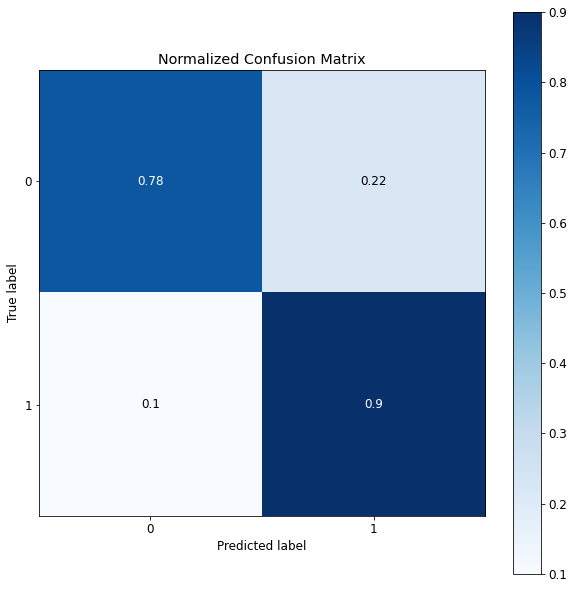

In [37]:
skplt.metrics.plot_confusion_matrix(pred, y_test, normalize=True)
plt.show()

# Try other models

In [38]:
df_test = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df_test.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [41]:
#select the text part and merge the title with the reviews
text_df = df_test[['Title', 'Review Text', 'Recommended IND']]
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
text_df.head()

/Users/sky/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Recommended,Review
0,1,NaN
1,1,NaN
2,0,"Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn dir..."
3,1,"My favorite buy! I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
4,1,Flattering shirt This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!


In [42]:
text_df.shape

(23486, 2)

In [44]:
text_df.dropna(inplace=True)
text_df.shape

(19675, 2)

In [46]:
#since the recommended is not balanced, so we need to upsample

from sklearn.utils import resample

#create two different dataframe of majority and minority class 
df_majority = text_df[(text_df['Recommended']==1)] 
df_minority = text_df[(text_df['Recommended']==0)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, replace=True,n_samples=15539 ,random_state=42)  




In [49]:
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled.shape

(31639, 2)

In [50]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [51]:
df_upsampled["Cleaned_Review"] = np.vectorize(remove_pattern)(df_upsampled["Review"], "@[\w]*")

In [53]:
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].str.replace("[^a-zA-Z#]", " ")

/Users/sky/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [56]:
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].apply(lambda x: " ".
                                        join([w for w in x.split() if len(w)>3]))

tokenized_tweet = df_upsampled["Cleaned_Review"].apply(lambda x: x.split())

In [71]:
def remove_punc(df):
    new_text= re.sub("n't",'not', df)
    new_text= re.sub('[^\w\s]','', df)
    return new_text


def remove_num(df):
    text_without_num=[w for w in df if w.isalpha()]
    return text_without_num

def tokenize(df):
    newdata= word_tokenize(df)
    return newdata


def remove_stops(df):    
    newdata=[t for t in df if t not in new_stopping_words]
    return newdata

def lemmatize(df):
    newdata= [WordNetLemmatizer().lemmatize(t) for t in df]
    return newdata

In [74]:
processed_text=remove_punc(str(df_upsampled["Cleaned_Review"]))
tokenized_data=tokenize(processed_text.lower())
textwithoutnum= remove_num(tokenized_data)
data = remove_stops(textwithoutnum)
final_data=lemmatize(data)

In [75]:
x = df_upsampled["Cleaned_Review"]
y= df_upsampled["Recommended"]

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import 
accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

In [80]:
#tokenization

from keras.preprocessing.text import Tokenizer
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x)
xtokens= tokenizer.texts_to_sequences(x)

In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen=50
xpad=pad_sequences(xtokens,padding='post', maxlen=maxlen)

X_train, X_test, y_train, y_test = train_test_split(xpad, y, test_size=0.2, stratify=y,random_state=42)

In [90]:
def result(model):
    
    #fit on data
    model.fit(x_train, y_train)
    
    #prediction
    pred = model.predict(x_test)
    
    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()
    
    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()
    
    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()
    
    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)

In [94]:
accuracy_list = []
f1_list = []
roc_auc_list = []

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3108
           1       0.97      0.97      0.97      3220

    accuracy                           0.97      6328
   macro avg       0.97      0.97      0.97      6328
weighted avg       0.97      0.97      0.97      6328

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9723451327433629
----------------------------------------------------------------------------------------------------

F1 Score:  0.9728049728049728
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9728049728049728
----------------------------------------------------------------------------------------------------



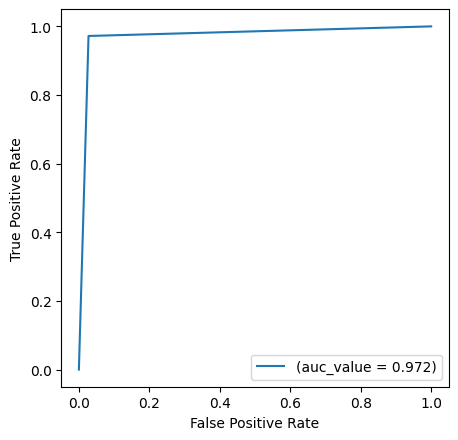


Confusion Matrix: 


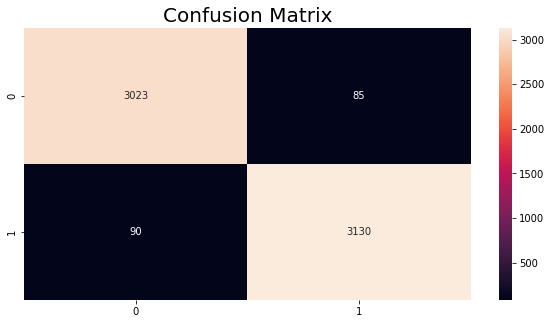

In [95]:
rf = RandomForestClassifier(criterion = 'entropy', random_state = 42)
result(rf)

Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.68      0.64      3108
           1       0.65      0.58      0.62      3220

    accuracy                           0.63      6328
   macro avg       0.63      0.63      0.63      6328
weighted avg       0.63      0.63      0.63      6328

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.6306890012642224
----------------------------------------------------------------------------------------------------

F1 Score:  0.6166967360997211
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.6166967360997211
----------------------------------------------------------------------------------------------------



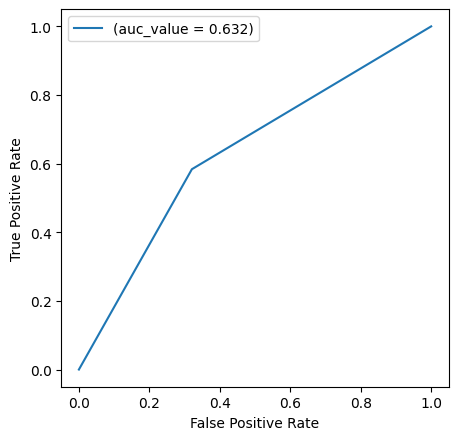


Confusion Matrix: 


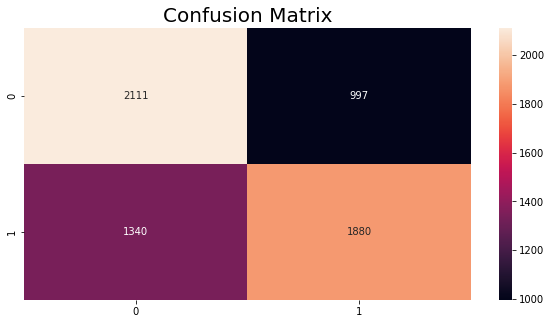

In [101]:
knn = KNeighborsClassifier(n_neighbors=30)
result(knn)